In [53]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    1: load_data('../stats/fpm_5_2D_x1.json'),
    2: load_data('../stats/fpm_5_2D_x2.json'),
    3: load_data('../stats/fpm_5_2D_x3.json'),
    4: load_data('../stats/fpm_5_2D_x4.json'),
    5: load_data('../stats/fpm_5_2D_x5.json'),
    6: load_data('../stats/fpm_5_2D_x6.json'),
}

# data = {
#     1: load_data('../stats/fpm_5_2D_direct_x1.json'),
#     2: load_data('../stats/fpm_5_2D_direct_x2.json'),
#     3: load_data('../stats/fpm_5_2D_direct_x3.json'),
#     4: load_data('../stats/fpm_5_2D_direct_x4.json'),
#     5: load_data('../stats/fpm_5_2D_direct_x5.json'),
#     6: load_data('../stats/fpm_5_2D_direct_x6.json'),
# }

In [54]:
shape = [3, 2]
figsize = (12, 6)

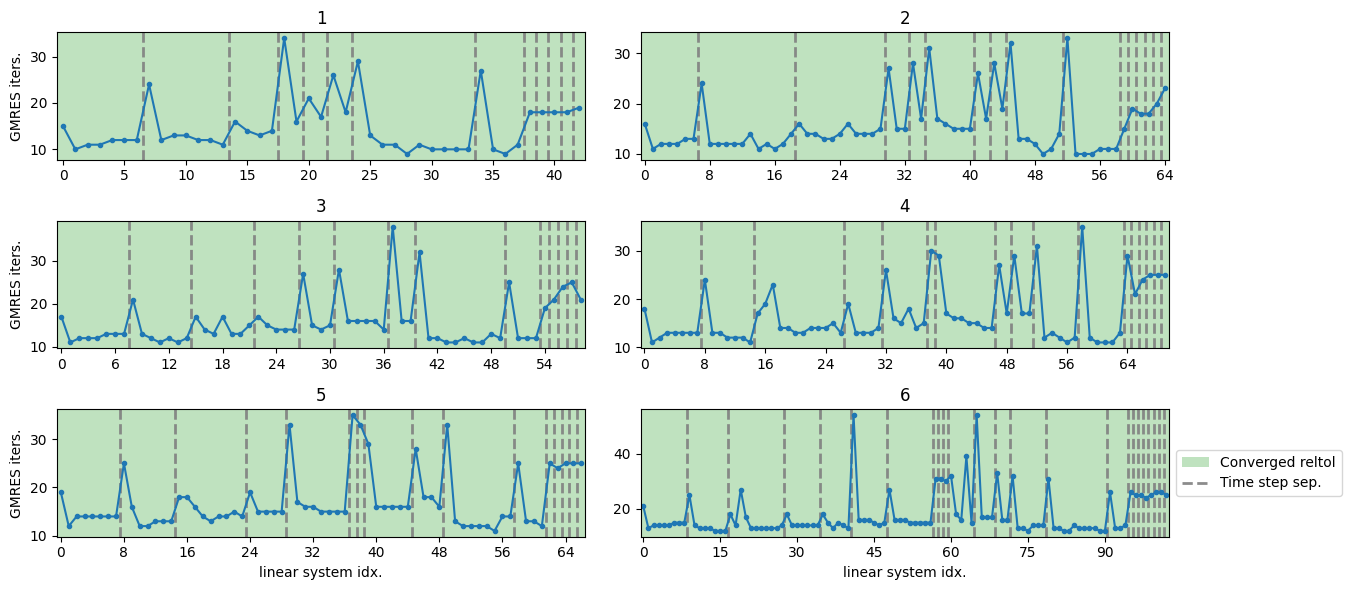

In [55]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

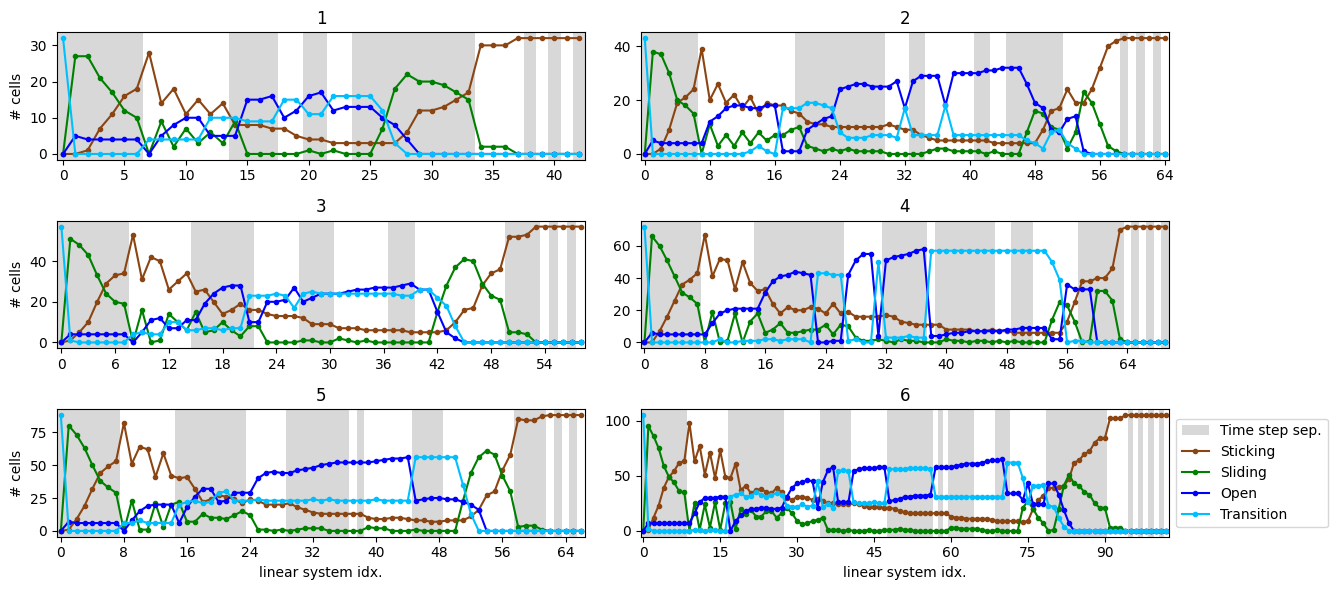

In [56]:
plot_grid(data, plot_sticking_sliding_open_transition, shape=shape, figsize=figsize, ylabel='# cells')

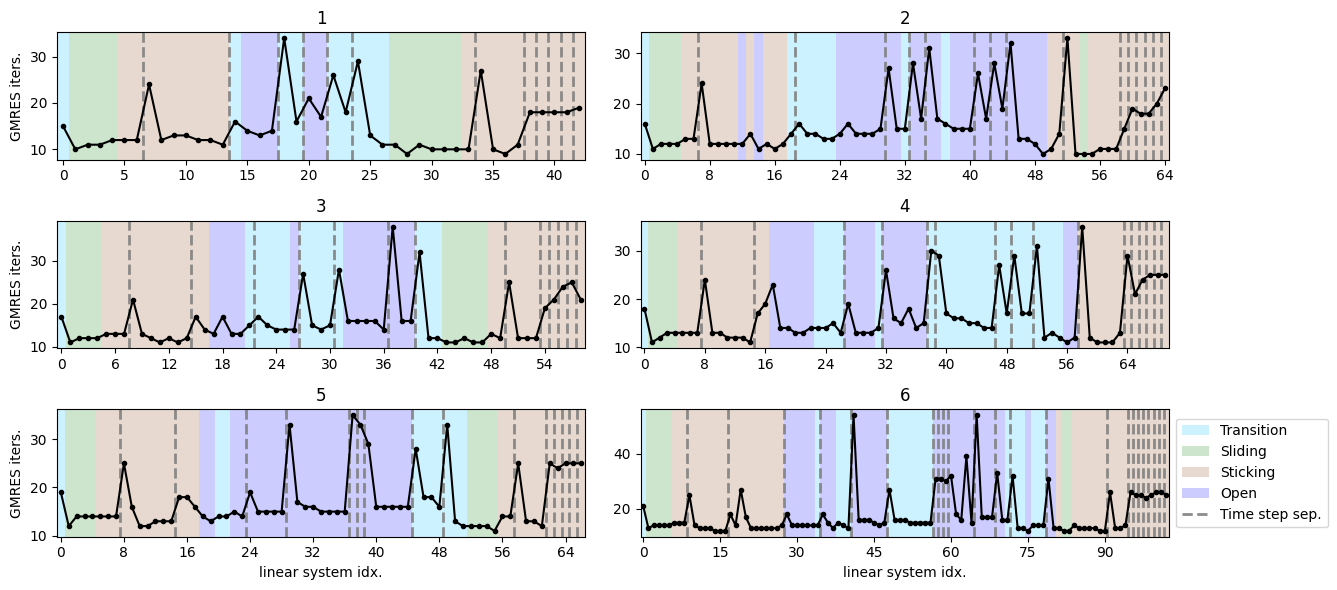

In [57]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')
    # plt.ylim(top=15)

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

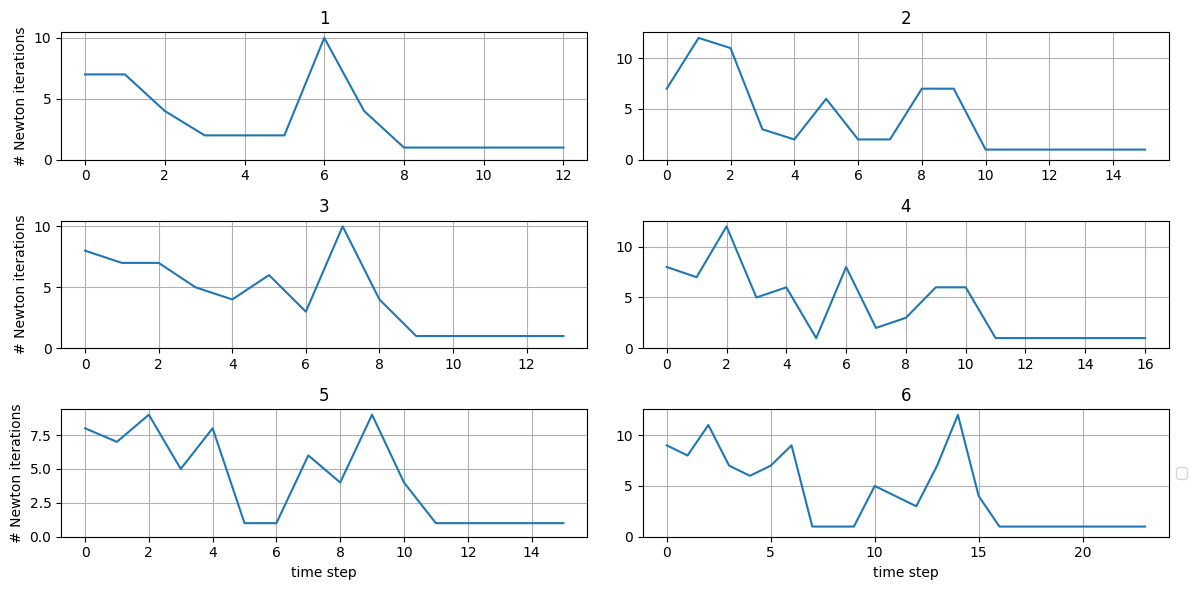

In [58]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step')

# Testing bad matrix

In [59]:
assert False

AssertionError: 

In [ ]:
from fpm_5_2D import make_model
cell_size_multiplier = 6
model = make_model(cell_size_multiplier=cell_size_multiplier)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 0
num sliding: 0
num open: 0
num transition: 105


In [ ]:
mat_idx = 15
entry = data[cell_size_multiplier]
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

13


In [ ]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

73
1
24
7


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 0.11
True residual permuted: 1.4743572532592554e-11
True residual: 1.4743572144095037e-11
PETSc Converged Reason: 2


{'mat_Q': BlockMatrixStorage of shape (14511, 14511) with 535192 elements with 6x6 active groups,
 'rhs_Q': array([-2.28364283e-08, -1.41945101e-07, -7.84659265e-09, ...,
        -2.82047217e-14, -1.75295895e-13, -1.72642493e-17])}

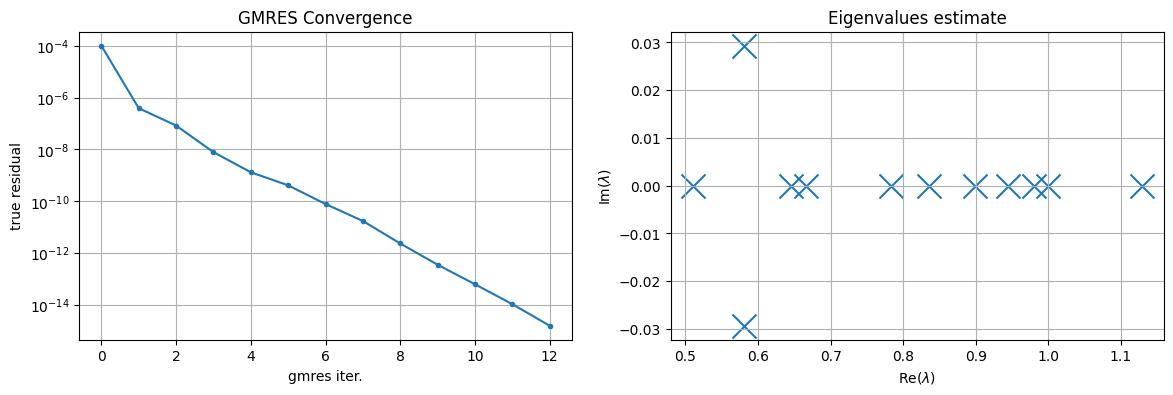

In [ ]:
sol = None
schema = model._prepare_solver()
solve_petsc_new(
    model.bmat,
    schema,
    rhs_global=rhs,
    # Qleft=model._Qleft,
    Qright=model.Qright,
    pc_side="right",
    tol=1e-10,
)

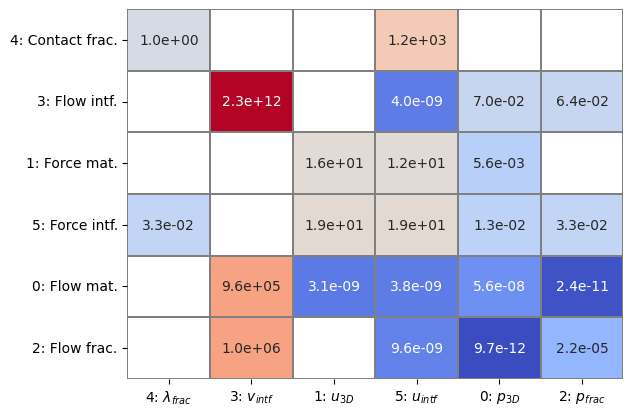

In [ ]:
model.bmat[[4, 3, 1, 5, 0, 2]].plot_max()

Solve  took: 0.06
True residual permuted: 4.54026206346007e-11
True residual: 78.86729588385968
PETSc Converged Reason: 2


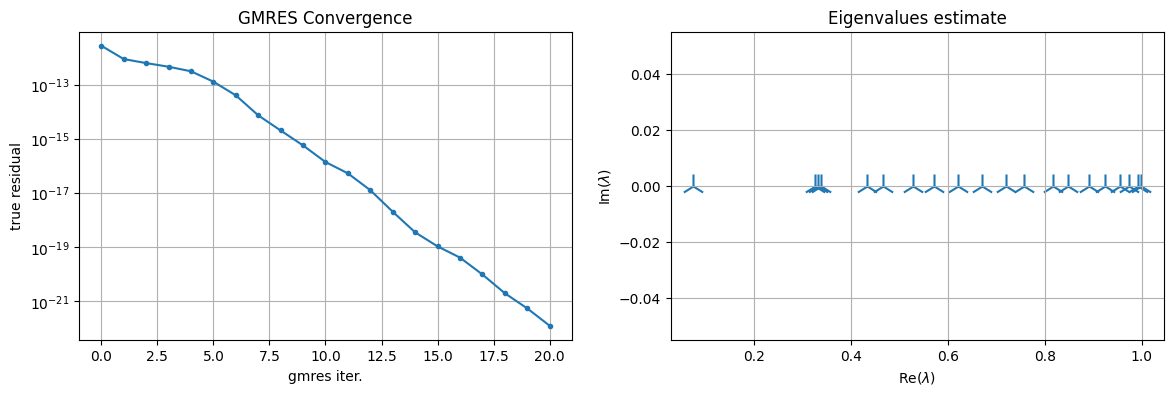

In [ ]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import *

schema = SolveSchema(
    # groups=[4],
    # only_complement=True,
    # complement=SolveSchema(
        # groups=[3],
        # solve=lambda bmat: PetscILU(bmat[[3]].mat),
        # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # groups=[5],
        # solve=lambda bmat: PetscAMGMechanics(mat=bmat[[5]].mat, dim=model.nd),
        # invertor=lambda bmat: inv_block_diag(bmat[[5]].mat, nd=model.nd, lump=True),
        # complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor_type="physical",
            invertor=lambda bmat: make_fs_experimental(model, bmat).mat,
            # complement=SolveSchema(
            #     groups=[0, 2],
            #     solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            # ),
        # ),
    # ),
)

res = solve_petsc_new(
    model.bmat,
    schema,
    # Qleft=model.Qleft,
    Qright=model.Qright,
    rhs_global=rhs,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)

Solve  took: 0.1
True residual decrease: 2.6870387050429228e-11
PETSc Converged Reason: 2


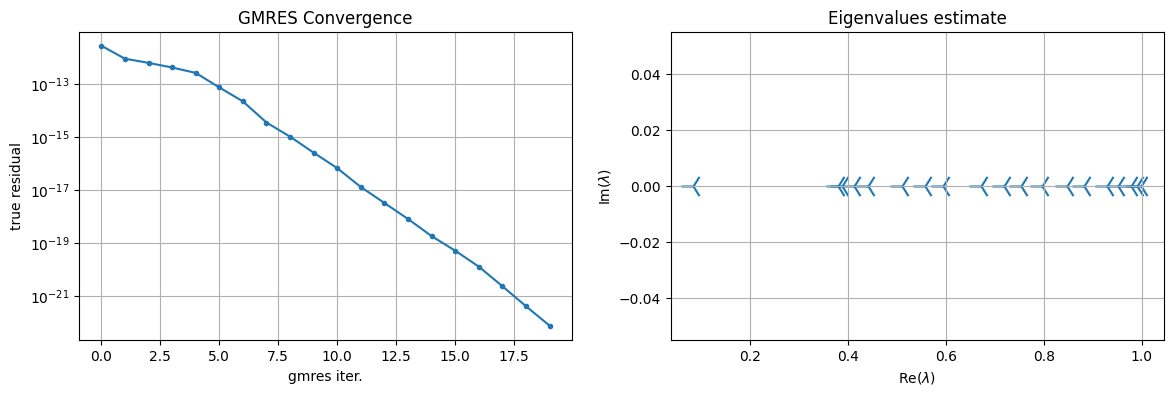

In [ ]:
matrix_cell_centers = model.mdg.subdomains(dim=model.nd)[0].cell_centers
cell_centers = [matrix_cell_centers] + [
    intf.cell_centers for intf in model.mdg.interfaces(dim=model.nd - 1)
]
cell_centers = np.concatenate(cell_centers, axis=1)

x, y, z = cell_centers
num_dofs = cell_centers.shape[1]

null_space = []
vec = np.zeros((2, num_dofs))
vec[0] = 1
null_space.append(vec.ravel("f"))
vec = np.zeros((2, num_dofs))
vec[1] = 1
null_space.append(vec.ravel("f"))
# vec = np.zeros((3, num_dofs))
# vec[2] = 1
# null_space.append(vec.ravel('f'))
# # 0, -z, y
vec = np.zeros((2, num_dofs))
vec[0] = -x
vec[1] = y
null_space.append(vec.ravel("f"))


# vec = np.zeros((3, num_dofs))
# vec[1] = -z
# vec[2] = y
# null_space.append(vec.ravel('f'))
# # z, 0, -x
# vec = np.zeros((3, num_dofs))
# vec[0] = z
# vec[2] = -x
# null_space.append(vec.ravel('f'))
# # -y, x, 0
# vec = np.zeros((3, num_dofs))
# vec[0] = -y
# vec[1] = x
# null_space.append(vec.ravel('f'))


null_space = np.array(null_space)
null_space

solve_petsc(
    model.bmat[[1, 5]].mat,
    PetscAMGMechanics(dim=model.nd, mat=model.bmat[[1, 5]].mat, null_space=null_space),
    rhs=model.bmat[[1, 5]].local_rhs(rhs),
    pc_side="right",
)

array([[ 2.16666667e-01,  2.50000000e-01,  2.83333333e-01,
         3.16666667e-01,  3.50000000e-01,  3.83333333e-01,
         4.16666667e-01,  4.50000000e-01,  4.83333333e-01,
         2.16666667e-01,  2.50000000e-01,  2.83333333e-01,
         3.16666667e-01,  3.50000000e-01,  3.83333333e-01,
         4.16666667e-01,  4.50000000e-01,  4.83333333e-01],
       [ 7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
         7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
         7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
         7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
         7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
         7.00000000e-01,  7.00000000e-01,  7.00000000e-01],
       [-1.48029737e-17, -1.11022302e-17, -7.40148683e-18,
        -3.70074342e-18, -2.33237820e-29,  3.70074342e-18,
         7.40148683e-18,  1.11022302e-17,  1.48029737e-17,
        -1.48029737e-17, -1.11022302e-17, -7.40148683e-18,
        -3.70074342e-18, -2.33237820e-29,  3.70074342e